In [3]:
#from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import psycopg2
import seaborn as sns
from sklearn.model_selection import train_test_split

# from shapely.wkt import loads as wkt_loads
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
# import geopandas as gp

# import h2o
# from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline 



In [42]:
try:
    conn = psycopg2.connect("dbname='crops' user='postgres' host='localhost' port='5433'")
    cur = conn.cursor()
except:
    print "Unable to connect to the database"

### EDA

In [5]:
def clean_values(x):
    if type(x) != str:
        return x
    
    x = x.lower()
    
    if "aardappel" in x:
        return "potato" 
    
    
    elif any(s in x for s in ["maïs" ,"mais"]):
        return "corn"

    elif any(s in x for s in ['gerst','gierst','tarwe','rogge','haver',\
                              'triticale','graan','granen','spelt','boekwei']):
        return "grain"    

    elif any(s in x for s in ["zaad" ,"zade"]):
        return "seed"    
        
    
    elif "gras" in  x:
        return "grass"
    
    
    elif "ui" in x:
        return "onion"
    
    

    
    elif any(s in x for s in ['bone','erwt','kapucijne']):
        return "beans"
   
    
    elif any(s in x for s in ['boom','bomen','note','fruit','vrucht',\
                              'appel','peren','kerst','kers','hout']):
        return "tree"
    
    elif any(s in x for s in ['bloem','klaver','koolzaad','raapzaad','tulp',\
                              'luzerne','tagete','cichorei','lupinen','sierconiferen'\
                              ,'buxus','sierheester','ericaceae','azalea','snijgroen',
                             'facelia','hennep','vlas','vezel','wikke','vaste planten']):
        return "flower"
    
    elif any(s in x for s in ['groenten','peen','wortel','prei','witlof','kool',\
                              'asperges','rabarber','sla','knolselderij','biet',\
                             'pompoen','spinazie','broccoli',\
                             'bladrammenas','radijs','peulen','mosterd',\
                             'schorseneren','andijvie','knolvenkel','courgette','pastinaak',
                             'valeriaan','knoflook','peterselie','paksoi',\
                              'bes','aardbei','frambo','selder','bram','braam',\
                             'komkommer','bladgewas']):
        return "veggies"
    


    elif any(s in x for s in ['fauna','natuur','bos','dummy','onbeteelde','sloot'\
                              ,'heide','onbekend','gegeven','open grond']):
        return "waste"
    
    else: return 'others'
    
    
#recursively join data with previous years
def get_backward_join_of_parcels(year,limit=2009,reference_year=False):
    
    #as id'+ str(year) + '
    if reference_year:
        q = 'select gid, cell_id, soil, next_year_parcel_fk as fk, gws_gewas as c'+ str(year) + ' from "' + str(year) + '"'
    else: 
        q = 'select gid , next_year_parcel_fk  as fk, gws_gewas as c'+ str(year) + ' from "' + str(year) + '"'
        
        
        
    df =  pd.read_sql_query(q,conn)
    
    #clean crop values without messing other columns
    if reference_year : 
        tempcols = df[['soil',"cell_id"]]
        df = df.drop(['soil',"cell_id"],axis=1).applymap(clean_values)
        df.insert(0,"cell_id",tempcols.cell_id )
        df.insert(0,"soil",tempcols.soil )

    else:
        df = df.applymap(clean_values)
    #end cleaning
    
    
    
        
    if year > limit:
        nextdf = get_backward_join_of_parcels(year-1,limit)
        nextdf = nextdf.drop('gid',axis=1)
        merged = df.merge(nextdf,how="left",left_on = 'gid', right_on = 'fk')
        merged.drop('fk_y',axis=1, inplace=True)
        merged.rename(columns={'fk_x': 'fk'}, inplace=True)
        
            
        
        return merged
    
    else: #edge case, end recursion
        return df

# df15 = get_backward_join_of_parcels(2015)




In [7]:
df10 = get_backward_join_of_parcels(2010,reference_year=True)


In [38]:
all_years_df = pd.DataFrame()
for year in range(2009,2017):
    solodf = get_backward_join_of_parcels(year,year)
    solodf = solodf.fillna('others')
    all_years_df.insert(0,str(year),solodf['c'+str(year)].value_counts())

In [107]:
all_years_df['2012']

grass      495571.0
corn       100981.0
grain       44943.0
potato      31760.0
onion       31250.0
waste       20144.0
seed        20152.0
tree        14609.0
flower      12127.0
others        505.0
beans         823.0
veggies         NaN
Name: 2012, dtype: float64

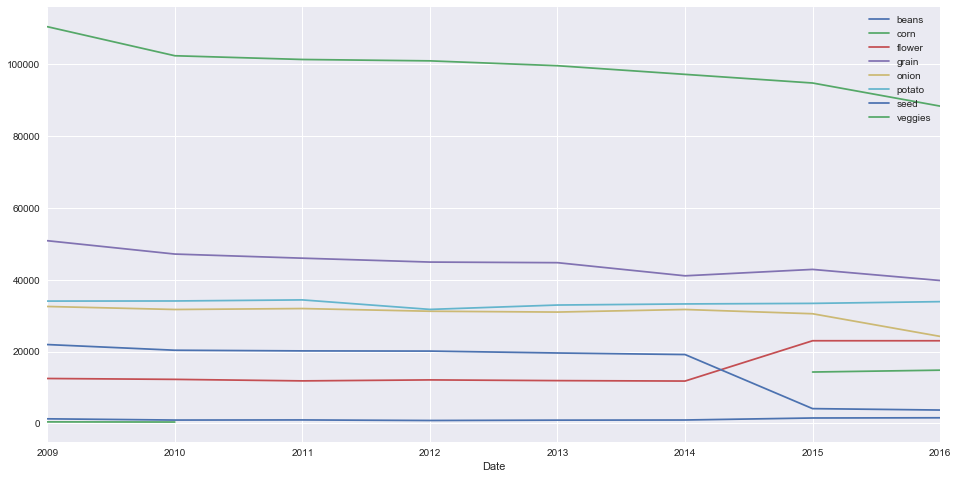

In [111]:
fig, ax = plt.subplots(figsize=(16,8))

melteddf = pd.melt(all_years_df.reset_index(),id_vars=["index"], 
                  var_name="Date", value_name="Value")

melteddf = melteddf.sort_values("Date", axis=0)
melteddf = melteddf[melteddf["index"]\
                    .apply((lambda x: False if any(s in x for s in ["tree","waste","grass","others"]) else True))]

for label, df in melteddf.groupby('index'):
    df.plot(kind="line",x="Date",y="Value", ax=ax, label=label)
# bp = p_df.groupby('class').plot(kind='kde', ax=ax)

plt.legend()    
# # bp = melteddf.groupby('index').plot(kind='line',x="Date", ax=ax,by='index')

In [127]:
melteddf[melteddf['index']=="potato"]

,index,Date,Value
87,potato,2009,34078.0
75,potato,2010,34107.0
63,potato,2011,34407.0
51,potato,2012,31760.0
39,potato,2013,32978.0
27,potato,2014,33282.0
15,potato,2015,33437.0
3,potato,2016,33922.0


In [113]:
df16 = get_backward_join_of_parcels(2016,2009,True)

# df14 = get_backward_join_of_parcels(2014,2009,True)

    

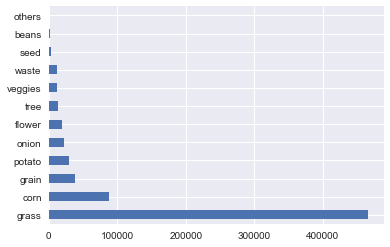

In [138]:
df16.drop('fk',axis=1,inplace=True)
df16.c2015.value_counts().plot(kind='barh')

In [139]:
df16.isnull().sum()

soil           71
cell_id         0
gid             0
c2016           0
c2015       75985
c2014      135702
c2013      178223
c2012      203009
c2011      229724
c2010      252030
c2009      278715
dtype: int64

In [207]:
print "Percent of parcels changed from last year {0:.2f}%".format(refDf.c2015.isnull().sum() *100.0/ len(refDf))

Percent of parcels changed from last year 9.73%


In [153]:
nna_ref = df16.dropna() 
potatos = nna_ref[nna_ref.c2016.apply(lambda x: True if "potato" in x.lower() else False)]




In [144]:
potatos.soil.value_counts()

Zand              9416
Lichte zavel      3503
Zware zavel       2444
Lichte klei       1346
Veen               680
Moerig op zand     507
Leem               420
Zware klei         251
Bebouwing, enz      69
Water                7
Name: soil, dtype: int64

#ToDO check those on water  

In [156]:
potatos = potatos.applymap(lambda x: 1 if x=="potato" else 0)

In [159]:
potatos.sum(axis=1).value_counts()

2    6333
3    5259
1    3753
4    2984
5     282
6      26
8       4
7       2
dtype: int64

In [226]:
df_agg  = nna_ref.groupby(['soil','c2016']).agg({'gid':'count'})
g = df_agg['gid'].groupby(level=0, group_keys=False)
res = g.nlargest(5)
# res.plot(kind='barh',figsize=(5,10))
res.index
#ToDo add subplots based on soil type

MultiIndex(levels=[[u'Bebouwing, enz', u'Leem', u'Lichte klei', u'Lichte zavel', u'Moerig op zand', u'Veen', u'Water', u'Zand', u'Zware klei', u'Zware zavel'], [u'Aardappelen, consumptie', u'Aardappelen, poot NAK', u'Aardappelen, zetmeel', u'Bieten, suiker-', u'Grasland, blijvend', u'Grasland, natuurlijk. Areaal met een natuurbeheertype dat overwegend voor landbouwactiviteiten-GLB wordt gebruikt', u'Grasland, natuurlijk. Hoofdfunctie landbouw.', u'Grasland, natuurlijk. Hoofdfunctie natuur.', u'Grasland, tijdelijk', u'Maïs, snij-', u'Tarwe, winter-']],
           labels=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9], [4, 8, 6, 9, 7, 4, 9, 10, 8, 3, 4, 8, 10, 9, 0, 4, 8, 9, 10, 1, 4, 8, 9, 6, 2, 4, 6, 8, 5, 9, 4, 6, 5, 7, 8, 4, 9, 8, 0, 2, 4, 8, 9, 10, 6, 4, 8, 9, 10, 0]],
           names=[u'soil', u'c2016'])

### Prediction

In [292]:
## TEST ## 
#rename df columns

# d = {}
# cols = refDf.ix[:1,"c2016":].columns.values
# for i in range(len (cols[1:])+1):
#     d[cols[i]]= str(i)
    
# d[cols[0]]= "y"
# tdf = refDf.copy()
# tdf.rename(columns=d)



# rename columns dic
# d = {}
# for di in range (1,5):
#     d[str(di)] = []
# d['y']= []
# mldf = pd.DataFrame(d)
# mldf

In [55]:
# USAGE: pd.concat([df10, append_nils_for_previous_years(2010,len(df10))], axis=1)

def append_nils_for_previous_years(year, length,window=4): 
    nullDF = pd.DataFrame()

    for y in range (2008,year-window, -1):
        nullDF[("c"+str(y))] = [np.NaN]*length
        
        
    return nullDF    


def create_dataset(start,end,window=4, prune_grass=False): #min 2010, max 2016
#     y = []
#     X = []

    #create base dataframe and append results of each loop
    #we rename columns to 1:window so that columns across varying windows can be concatenated
    d = {}
    for di in range (1,window+1):
        d[str(di)] = []
    d['y']= []
    mldf = pd.DataFrame(d)
    
    
    for year in range(start,end+1):
        join_df = get_backward_join_of_parcels(year,max(year-window,2009),True)
       
        # one way is to pad from 2003 to 2008 with zeros. 
        join_df = pd.concat([join_df, append_nils_for_previous_years(year,len(join_df),window)], axis=1)
#         print 'after null', join_df.head(1)
        print "adding target ", year 
        join_df = join_df[~join_df[("c"+str(year-1))].isnull()] # prediction target is join of this year's data with that of next year 
#         X.extend(join_df.ix[:,("c"+str(year-1)):].values)
#         y.extend(join_df.ix[:,("c"+str(year))].values)
        
        #rename columns
        
        d = {}
        cols = join_df.ix[:1,("c"+str(year)):].columns.values
        for i in range(len (cols[1:])+1):
            d[cols[i]]= str(i)

        d[cols[0]]= "y"
        join_df.rename(columns=d,inplace=True)        
        join_df.drop(['gid','fk'],axis=1,inplace=True)
        
        #not working
#         if prune_grass: #remove all parcels that have had value 'grass' across ALL the years
#             join_df = join_df[join_df.apply(lambda row: False if \
#                                             (np.unique(row.values[0:window])==['grass'])[0] \
#                                             else True,axis=1)]

        #append to existing dataset
        mldf = pd.concat([mldf,join_df])
        

    return mldf

t = create_dataset(2015,2016,6)      


adding target  2015
adding target  2016


In [44]:


tprime = t[t.apply(lambda row: False if (np.unique(row.values[0:5])==['grass'])[0] else True,axis=1)]



/Users/aoliya/anaconda/envs/test_fiona5/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [53]:
len(tprime)

1740067

In [54]:
len(t)

2788383

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing 

def train_validate_predict(df,weights=None):
    
#   it seems decision tree/random forest can still work ok with integers   
#     le = preprocessing.LabelEncoder()
#     le.fit(np.unique(df.values.reshapre(1,-1)))
#     df = df.apply(le.transform, axis=1)
#     df = pd.get_dummies(df,dummy_na=True)
    
    df = df.sample(frac=1) #randomize    
    traindf = df.iloc[0:int(0.7*len(df))]
    testdf = df.iloc[int(0.7*len(df)):]

    X_train, X_valid, y_train, y_valid = train_test_split(traindf.ix[:,0:len(df.columns)-1],\
                                                          traindf.ix[:,len(df.columns)-1],\
                                                          test_size=0.33, random_state=19,\
                                                          stratify=traindf.ix[:,len(df.columns)-1])


    X_test = testdf.ix[:,0:len(df.columns)-1]
    y_test = testdf.ix[:,len(df.columns)-1]

    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,class_weight=weights, random_state=557) #set class weight for potatos 
    clf.fit(X_train,y_train)

    print "Results on validation set:\n"
    print(classification_report(y_valid, clf.predict(X_valid)))

    # print "And results on test set:\n"
    # print(classification_report(X_test,y_test ))

    

In [233]:
from sklearn import preprocessing 

t_simple = t.drop(["cell_id","soil"],axis=1)
t_simple.fillna("others",inplace=True)

le = preprocessing.LabelEncoder()
le.fit(np.unique(t_simple.values.reshape(1,-1)))
t_simple = t_simple.apply(le.transform)
t_simple.reset_index().drop('index',axis=1,inplace=True)

print le.classes_

['beans' 'corn' 'flower' 'grain' 'grass' 'onion' 'others' 'potato' 'seed'
 'tree' 'veggies' 'waste']


In [235]:
train_validate_predict(t_simple,"balanced")

Results on validation set:

             precision    recall  f1-score   support

          0       0.01      0.21      0.03       979
          1       0.75      0.69      0.72     80570
          2       0.46      0.44      0.45     13131
          3       0.53      0.49      0.51     34225
          4       0.97      0.94      0.95    426487
          5       0.45      0.37      0.41     22415
          6       0.02      0.31      0.03       423
          7       0.41      0.46      0.44     27310
          8       0.35      0.50      0.41      9304
          9       0.72      0.78      0.75     11052
         10       0.31      0.31      0.31      5423
         11       0.84      0.80      0.82     12748

avg / total       0.84      0.81      0.83    644067



Results on validation set:

             precision    recall  f1-score   support

          0       0.21      0.01      0.02       705
          1       0.38      0.05      0.08       174
          2       0.00      0.00      0.00       474
          3       0.69      0.80      0.74     61692
          4       0.68      0.52      0.59      6571
          5       0.49      0.62      0.55     25989
          6       0.96      0.96      0.96    316314
          8       0.51      0.37      0.43     17549
          9       0.57      0.38      0.45     15814
         10       0.54      0.40      0.46     20231
         11       0.36      0.21      0.26      1938
         12       0.61      0.89      0.73      5575
         13       0.85      0.75      0.79      8258

avg / total       0.84      0.84      0.84    481284



#### with soil

In [148]:
tsoil = t.drop('cell_id',axis=1)
tsoil = tsoil.fillna('others')
ls = preprocessing.LabelEncoder()
ls.fit(np.unique(tsoil.values.reshape(1,-1)))
tsoil = tsoil.apply(ls.transform)
tsoil.reset_index().drop('index',axis=1,inplace=True)

print ls.classes_

In [152]:
train_validate_predict(tsoil)

Results on validation set:

             precision    recall  f1-score   support

         12       0.11      0.01      0.02       666
         13       0.29      0.05      0.08       177
         14       0.69      0.80      0.74     61751
         15       0.66      0.50      0.57      6554
         16       0.52      0.61      0.56     25955
         17       0.96      0.96      0.96    316234
         18       0.49      0.39      0.43     17517
         19       0.58      0.37      0.45     16370
         20       0.54      0.44      0.48     20324
         21       0.35      0.21      0.26      1954
         22       0.60      0.88      0.71      5528
         23       0.84      0.75      0.79      8254

avg / total       0.84      0.84      0.84    481284



In [95]:
tzegond = t[t.apply(lambda row: True if ('potato' in row.values[0:4])  else False,axis=1)]


In [46]:
from sklearn import preprocessing 


#with cell id 
nona = tprime[~tprime.soil.isnull()]
fishml = nona.drop('cell_id',axis=1)
fishml = fishml.fillna('others')

ls = preprocessing.LabelEncoder()
ls.fit(np.unique(fishml.values.reshape(1,-1)))
fishml = fishml.apply(ls.transform)

fishml.insert(0,"cell_id",nona.cell_id)
fishml.reset_index().drop('index',axis=1,inplace=True)


# train_validate_predict(fishml)

In [98]:
fishml[fishml.y==14]

,cell_id,1,2,3,4,soil,y
51,530.0,18,13,17,15,2,14
55,772.0,17,13,13,17,9,14
102,583.0,17,12,18,15,3,14
110,686.0,14,17,14,14,2,14
112,686.0,14,14,17,14,7,14
137,611.0,17,18,15,17,4,14
179,618.0,14,14,14,17,7,14
182,618.0,11,17,11,11,7,14
184,618.0,11,17,11,11,7,14
375,618.0,14,13,17,14,7,14


In [ ]:
fishml.plot(kind='line')

In [47]:
print len(ls.classes_),ls.classes_


22 ['Bebouwing, enz' 'Leem' 'Lichte klei' 'Lichte zavel' 'Moerig op zand'
 'Veen' 'Water' 'Zand' 'Zware klei' 'Zware zavel' 'beans' 'corn' 'flower'
 'grain' 'grass' 'onion' 'others' 'potato' 'seed' 'tree' 'veggies' 'waste']


##### changing class weights

In [50]:
train_validate_predict(fishml)

Results on validation set:

             precision    recall  f1-score   support

         10       0.12      0.06      0.08       961
         11       0.70      0.78      0.74     76754
         12       0.56      0.45      0.50     12575
         13       0.53      0.57      0.55     33974
         14       0.93      0.92      0.92    192408
         15       0.43      0.38      0.40     21798
         16       0.29      0.15      0.20       400
         17       0.53      0.49      0.51     25836
         18       0.42      0.39      0.40      9129
         19       0.72      0.77      0.74     10824
         20       0.44      0.32      0.37      5199
         21       0.85      0.79      0.82     12058

avg / total       0.76      0.76      0.76    401916



In [101]:

train_validate_predict(fishml,{17:100})

Results on validation set:

             precision    recall  f1-score   support

         10       0.11      0.05      0.07       103
         11       0.55      0.51      0.53      3666
         12       0.27      0.17      0.21       580
         13       0.55      0.55      0.55      4788
         14       0.67      0.60      0.63      2276
         15       0.37      0.32      0.34      2829
         16       0.00      0.00      0.00        39
         17       0.52      0.73      0.61      3860
         18       0.30      0.24      0.27      1313
         19       0.45      0.37      0.41        84
         21       0.45      0.29      0.35       185

avg / total       0.50      0.51      0.50     19723



In [ ]:
h2o.init()
# mlset = np.concatenate((np.array(X),np.array(y).reshape(-1,1)),axis=1)
hdf = h2o.H2OFrame.from_python(t)#,X.drop(['geom','center',],axis=1))

print hdf.tail(1)
gbm_classifier = H2OGradientBoostingEstimator(distribution="multinomial", \
                                              ntrees=10, max_depth=5, min_rows=2, learn_rate=0.2 , seed=577,balance_classes=True)

gbm_classifier.train(x=range(0,hdf.ncol), y=hdf.ncol-1, training_frame=hdf)

gbm_classifier

In [313]:
gbm_classifier.summary()

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,5.0,60.0,20465.0,2.0,2.0,2.0,4.0,4.0,4.0
